# Import Libraries and Read Data

In [ ]:
!pip install pandas scikit-learn imbalanced-learn

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

# Adjust file paths
data_file_path = r'C:\Users\abdog\DEDA_Project\FraudDetection-master\data_FraudDetection_JAR2020.csv'

# Read data
data = pd.read_csv(data_file_path)

# Example of filtering data by year
def filter_data_by_year(data, start_year, end_year):
    return data[(data['fyear'] >= start_year) & (data['fyear'] <= end_year)]

train_data = filter_data_by_year(data, 1991, 1999)
valid_data = filter_data_by_year(data, 2000, 2001)

X_train = train_data.iloc[:, 4:]
y_train = train_data['misstate']
X_valid = valid_data.iloc[:, 4:]
y_valid = valid_data['misstate']


# Handle Serial Frauds

In [14]:
# Handling serial frauds
def handle_serial_frauds(train_data, valid_data):
    valid_paaers = valid_data[valid_data['misstate'] != 0]['p_aaer'].unique()
    train_data.loc[train_data['p_aaer'].isin(valid_paaers), 'misstate'] = 0
    return train_data

train_data = handle_serial_frauds(train_data, valid_data)
X_train = train_data.iloc[:, 4:]
y_train = train_data['misstate']


# Preprocess Data to Handle NaNs

In [15]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)


# Train the Model

In [16]:
# Define and train the model
rusboost = RUSBoostClassifier(
    estimator=DecisionTreeClassifier(min_samples_leaf=5),
    n_estimators=300,
    learning_rate=0.1,
    random_state=0
)

rusboost.fit(X_train, y_train)


RUSBoostClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=5),
                   learning_rate=0.1, n_estimators=300, random_state=0)

# Predict and Evaluate


In [20]:
# Predict and evaluate
y_pred = rusboost.predict(X_valid)
y_dec_values = rusboost.predict_proba(X_valid)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_valid, y_dec_values)
print(f'AUC: {auc_score:.4f}')


AUC: 0.7396


# Define Visualization Functions

In [27]:
def plot_roc_curve(y_true, y_dec_values):
    fpr, tpr, _ = roc_curve(y_true, y_dec_values)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_dec_values):
    precision, recall, _ = precision_recall_curve(y_true, y_dec_values)
    average_precision = average_precision_score(y_true, y_dec_values)
    
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure()
    plt.title("Feature Importance")
    plt.bar(range(X_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


# Visualize Results

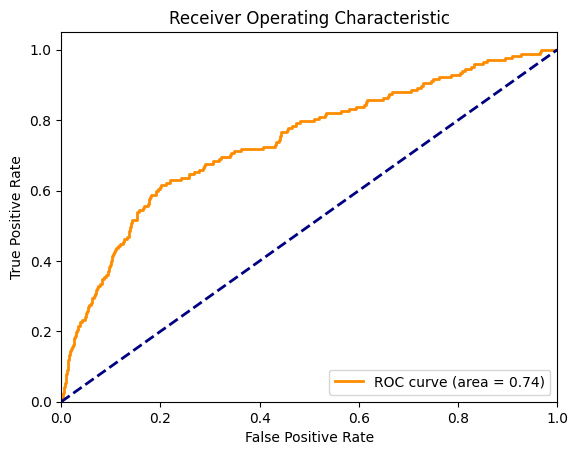

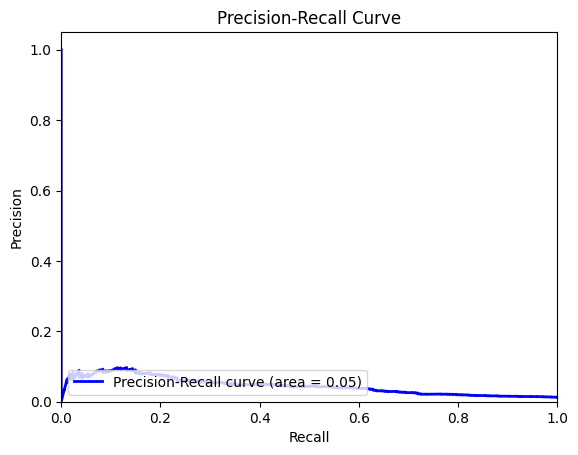

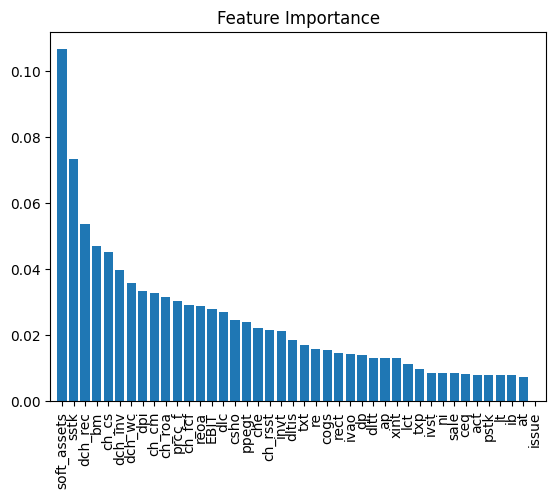

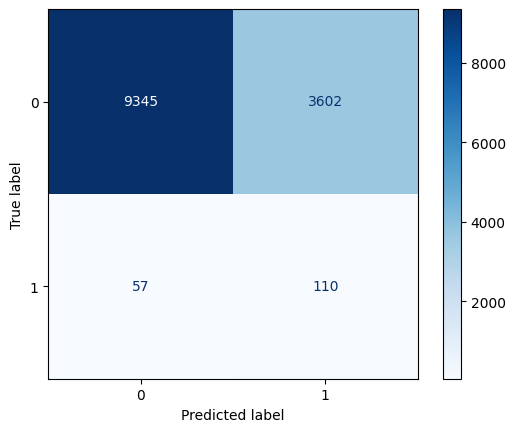

In [28]:
# Visualize results
plot_roc_curve(y_valid, y_dec_values)
plot_precision_recall_curve(y_valid, y_dec_values)
plot_feature_importance(rusboost, X_train.columns)
plot_confusion_matrix(y_valid, y_pred)
